In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import seaborn as sns
import torch
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import json
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [6]:
def plot_losses(losses, embedding):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(1, len(losses) + 1), y=losses, label='Loss')
    plt.title(f'Loss - {embedding}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.show()
    plt.savefig(f'Plots/loss_{embedding}.png')

def plot_f1s(f1_scores, embedding):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(1, len(f1_scores) + 1), y=f1_scores, label='F1 Score')
    plt.title(f'F1 Score - {embedding}')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    # plt.show()
    plt.savefig(f'Plots/f1_{embedding}.png')

# Plotting Baseline models

/var/folders/jj/dgg170f96xdb_9rd0w_skrv00000gn/T/ipykernel_91722/3857515835.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


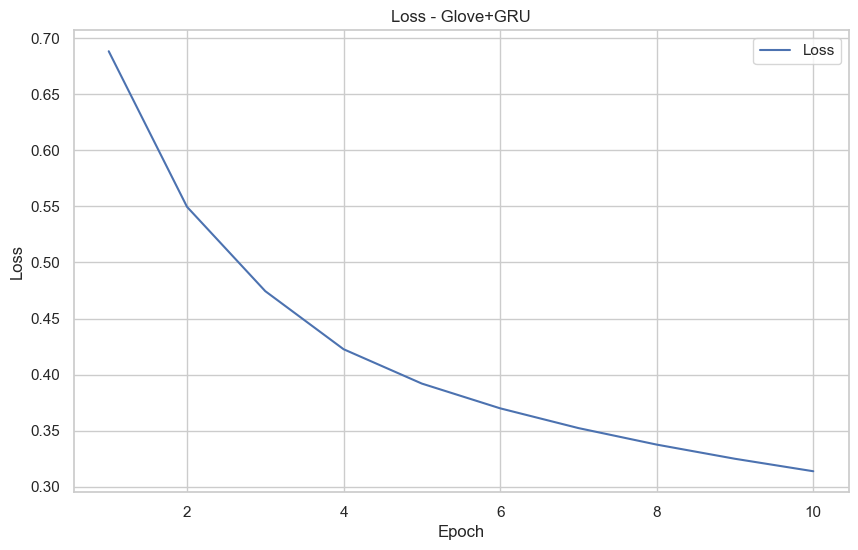

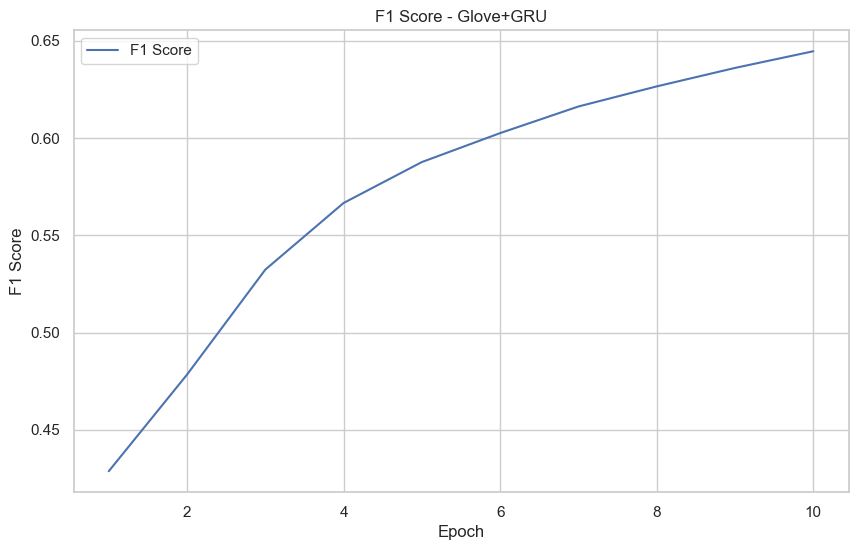

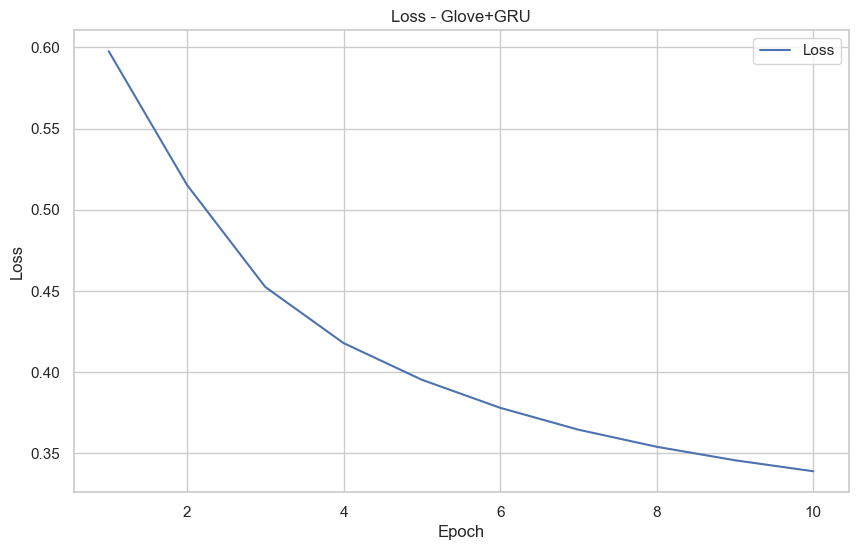

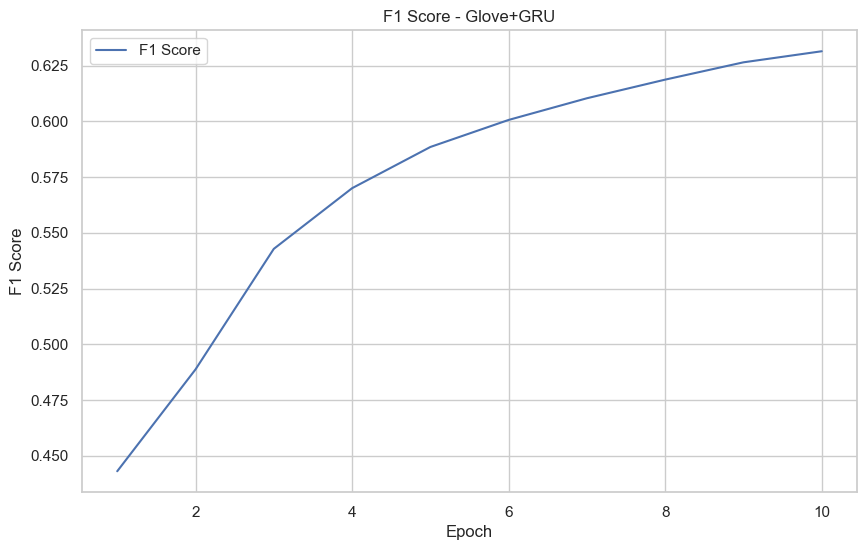

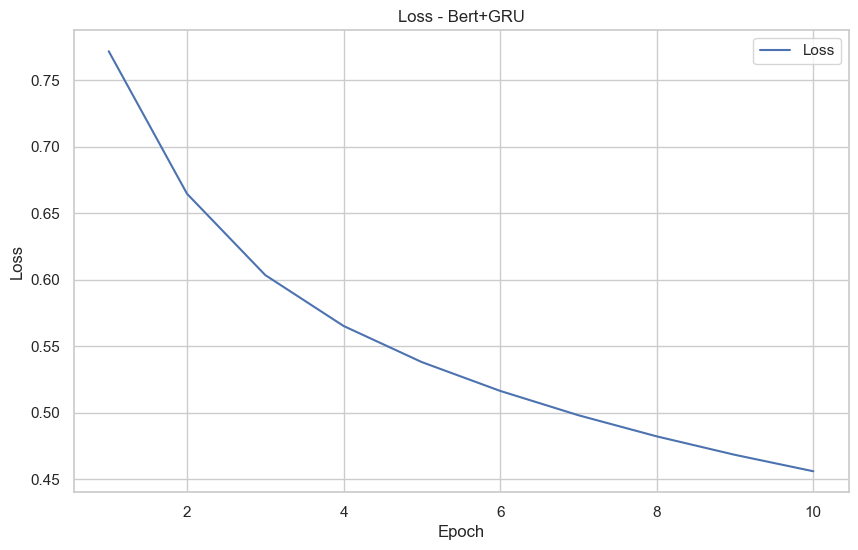

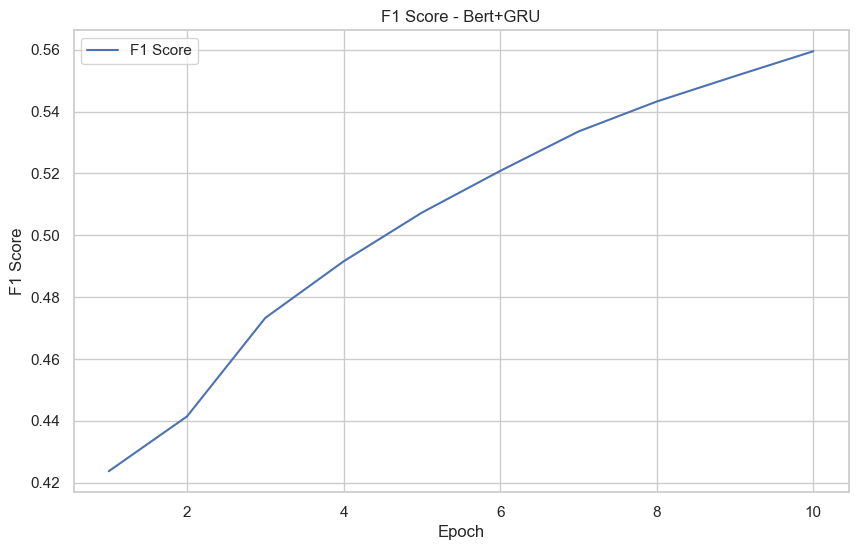

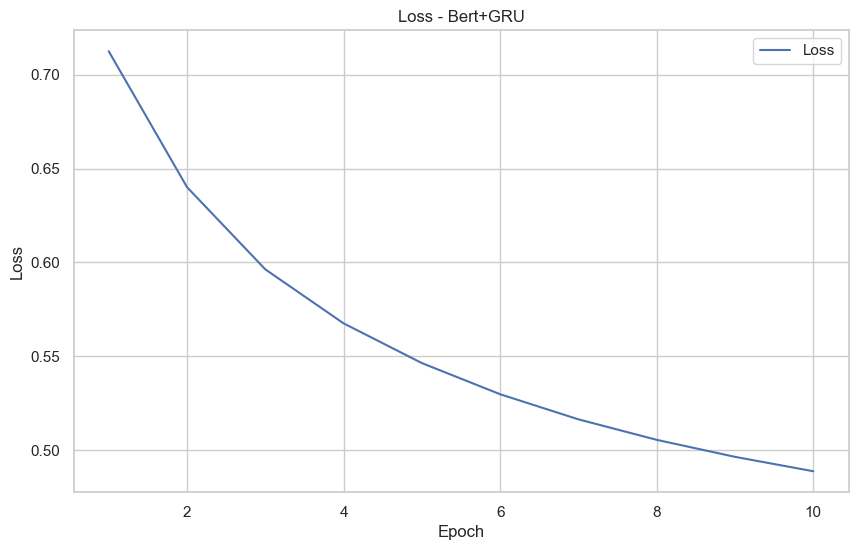

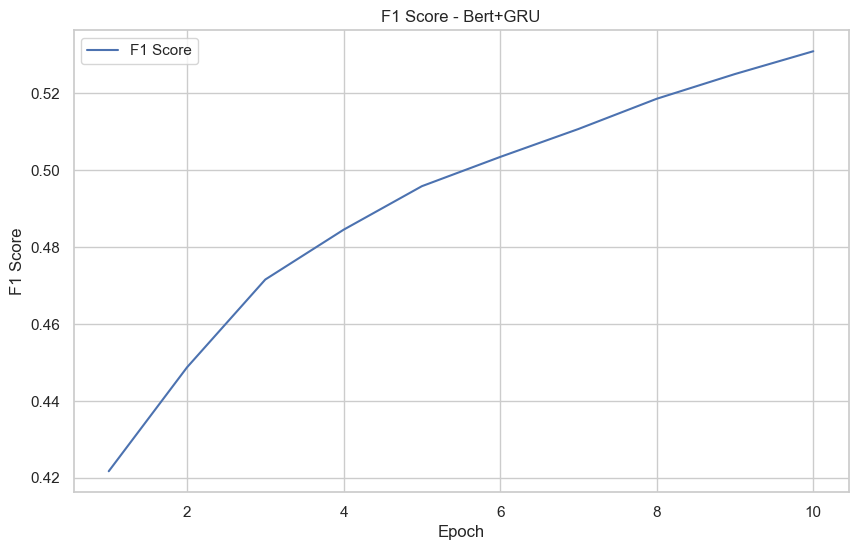

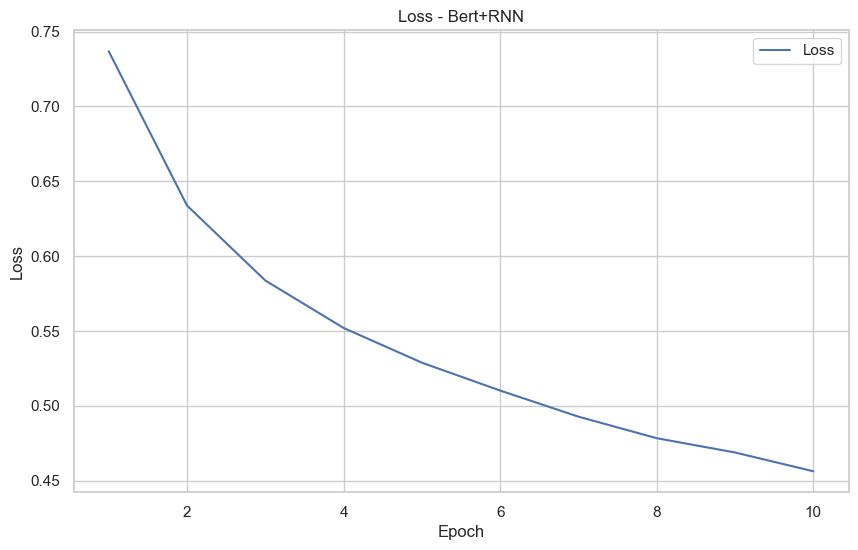

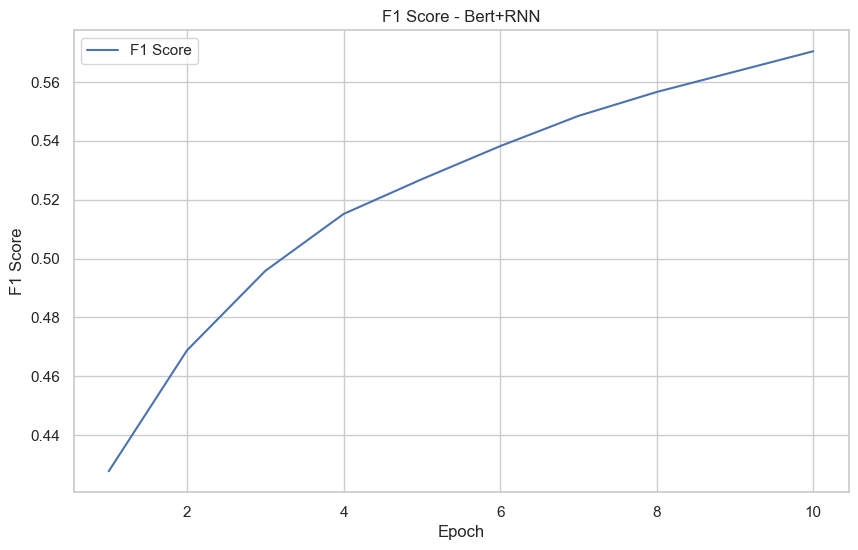

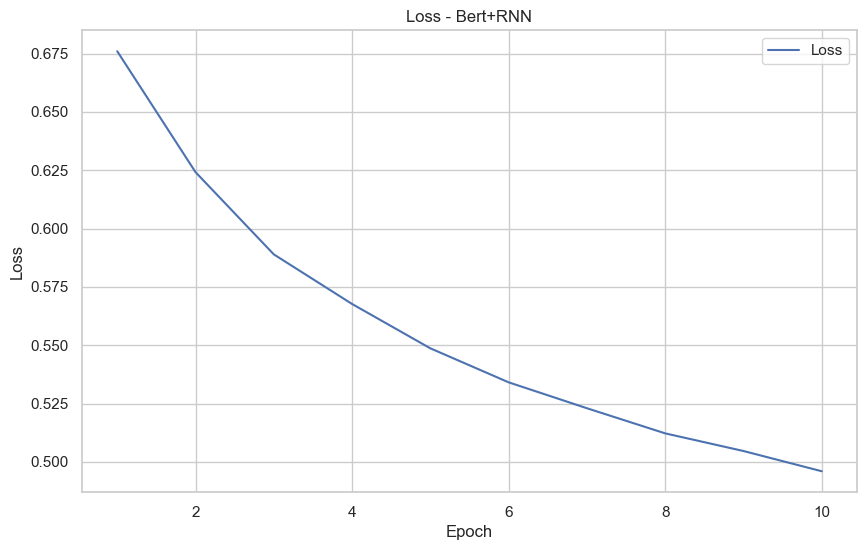

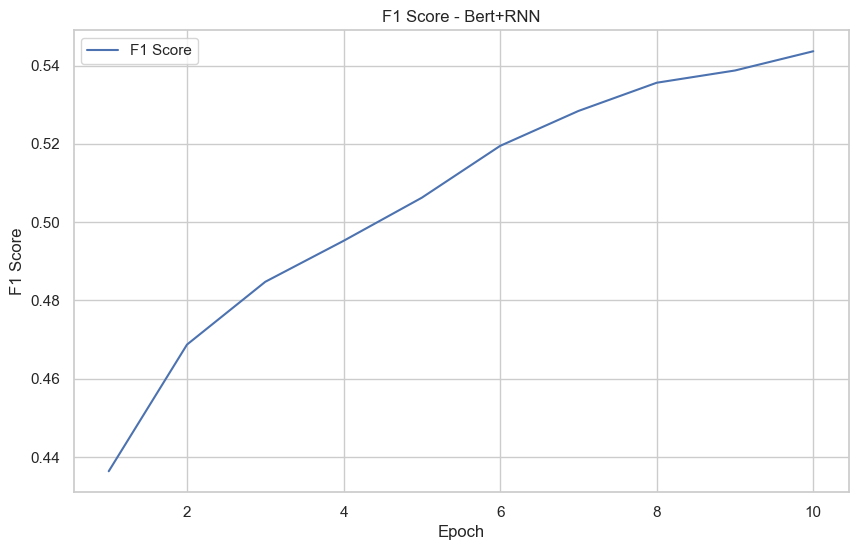

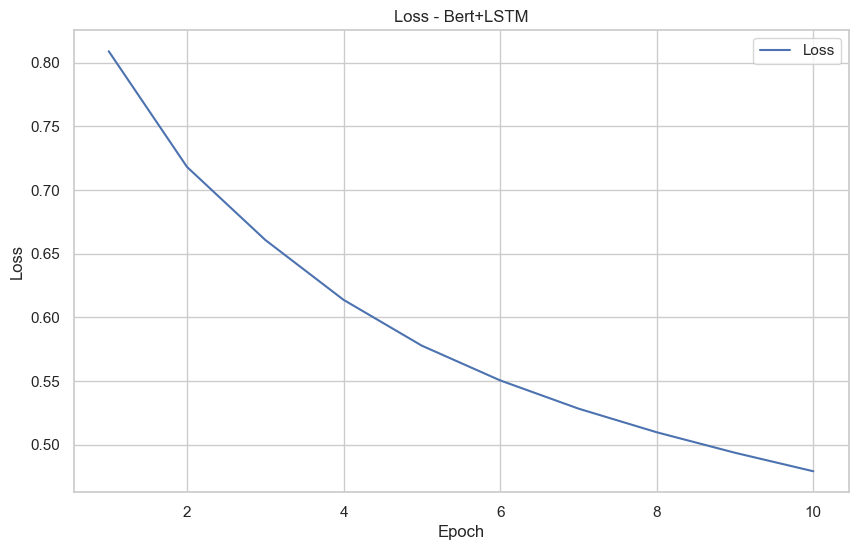

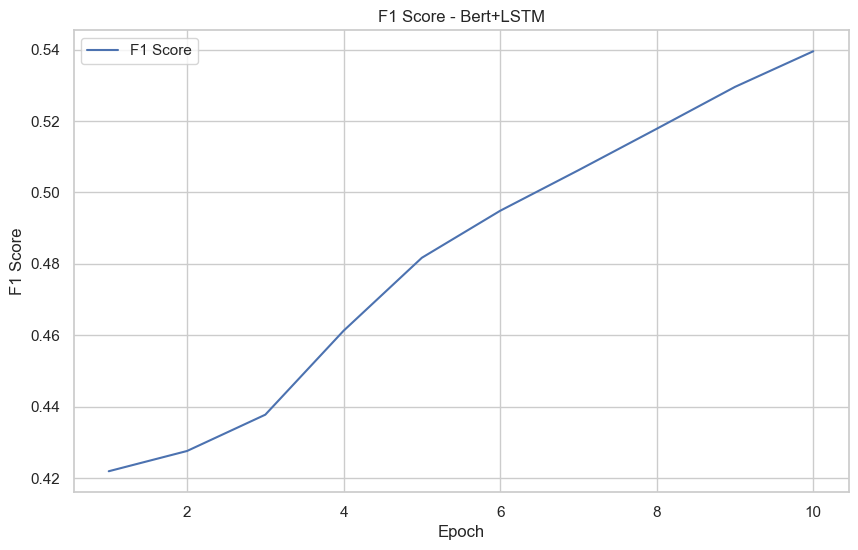

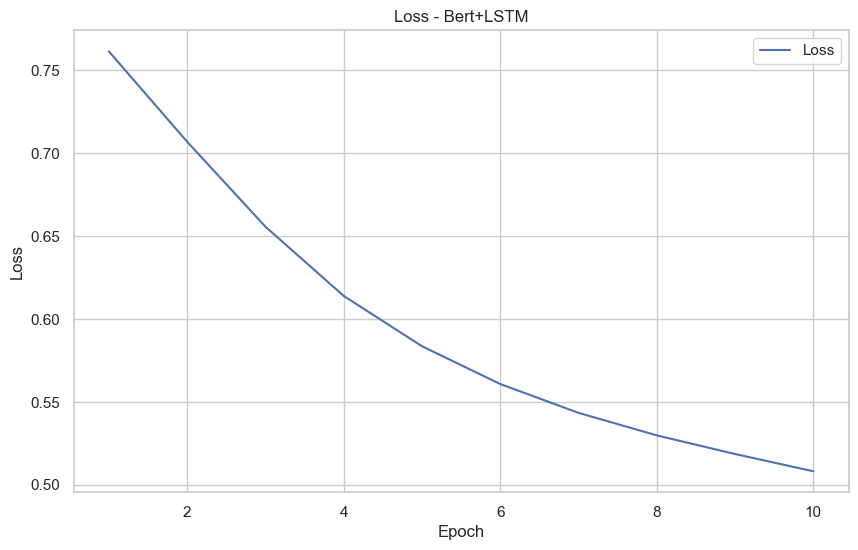

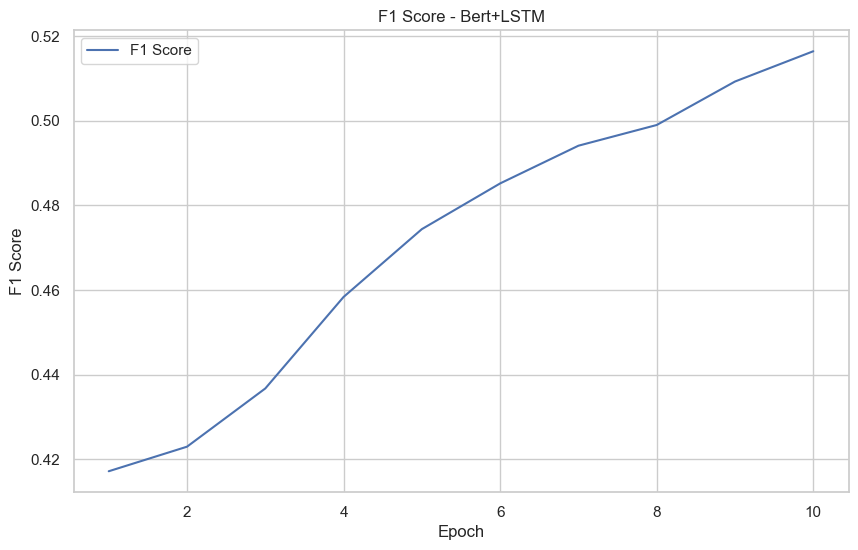

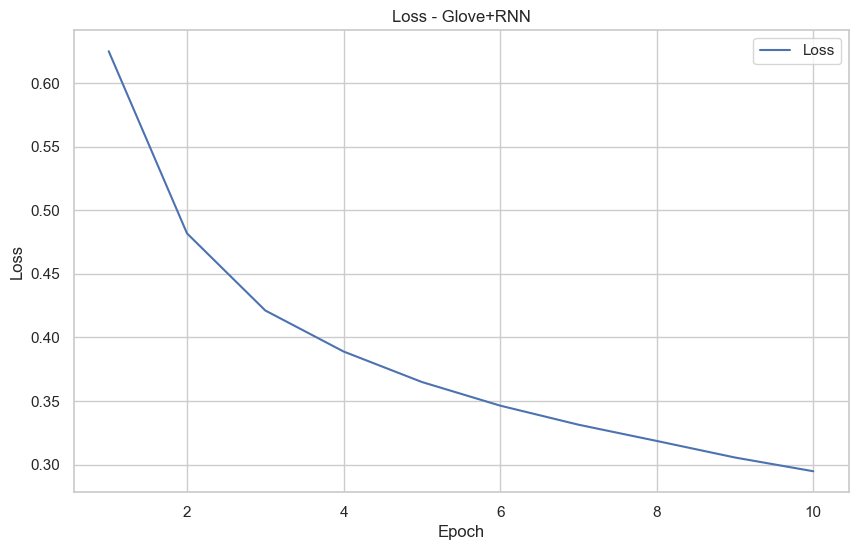

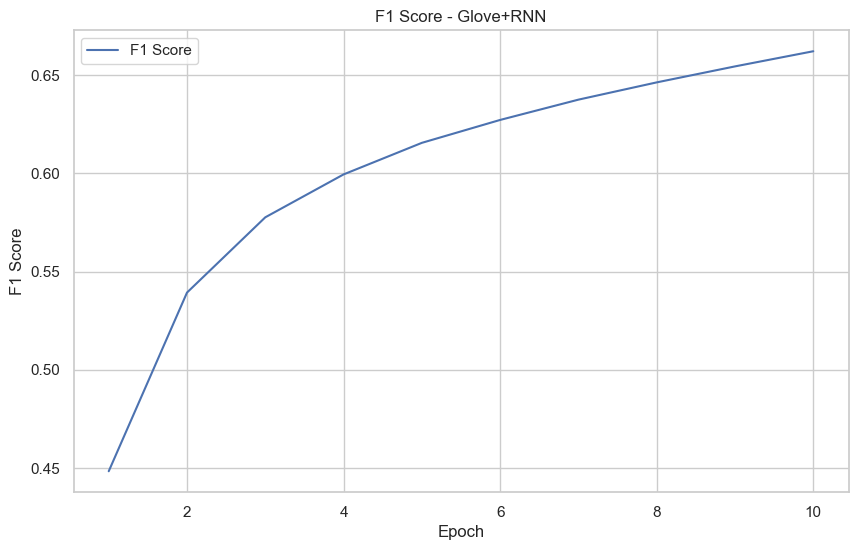

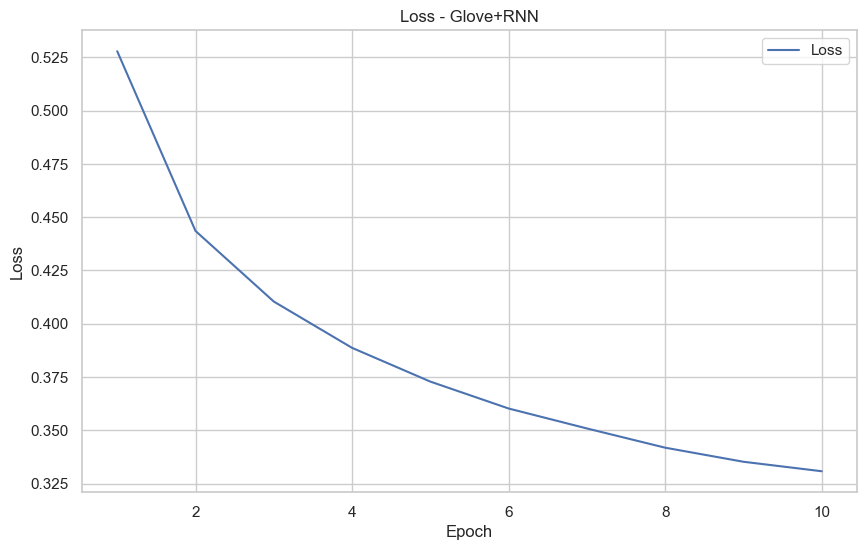

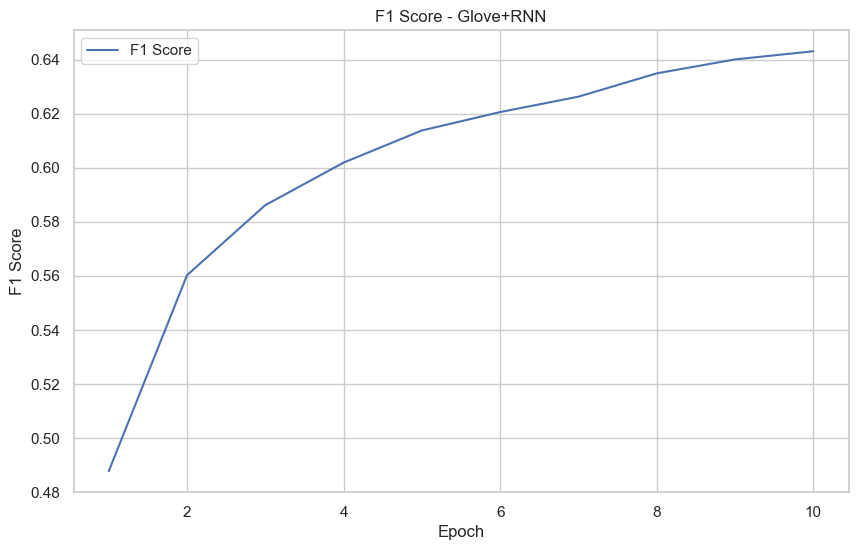

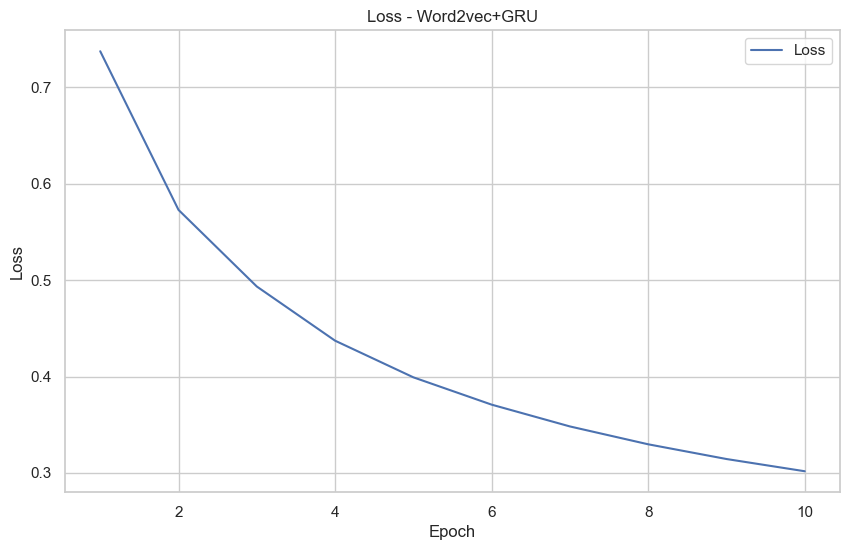

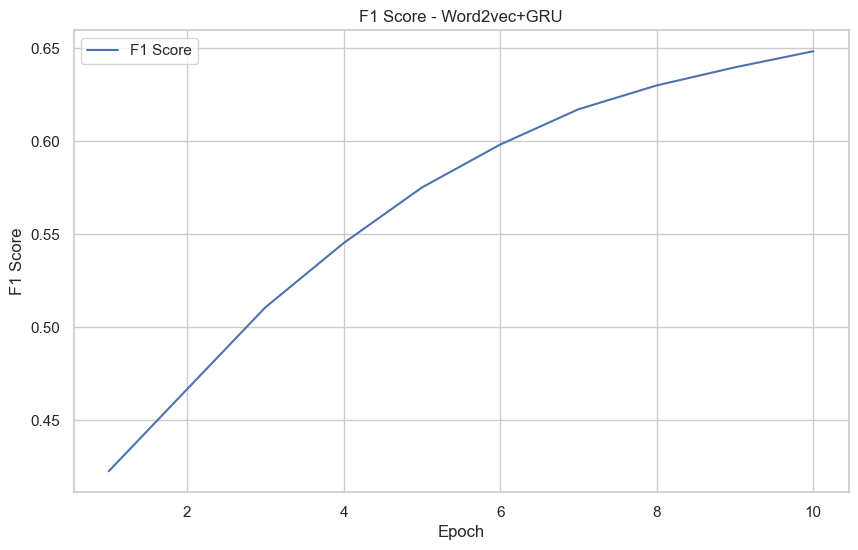

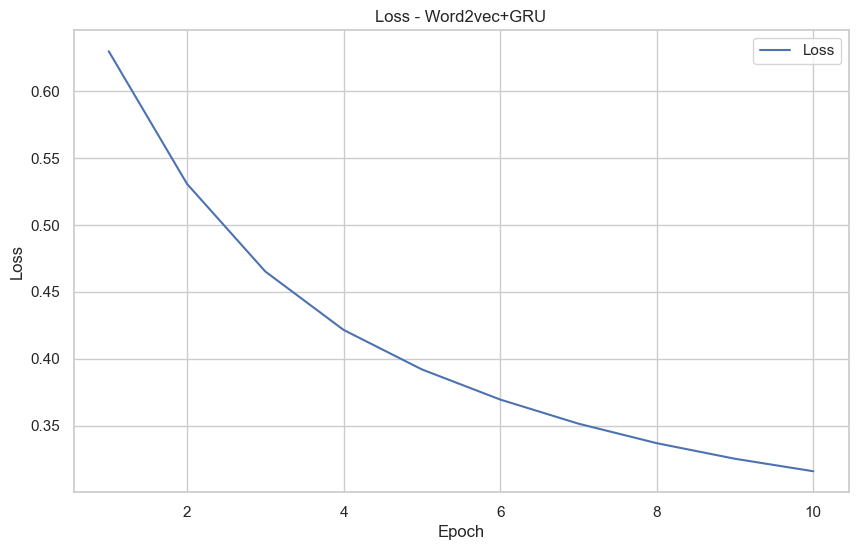

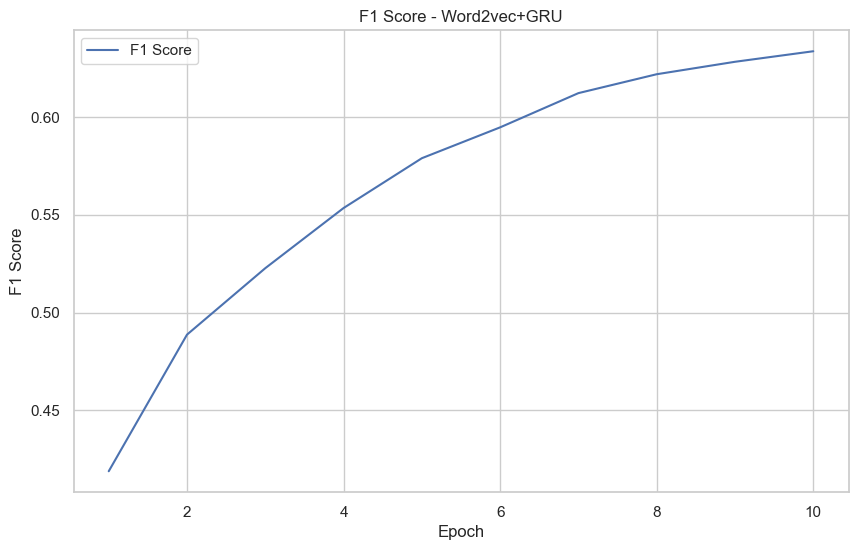

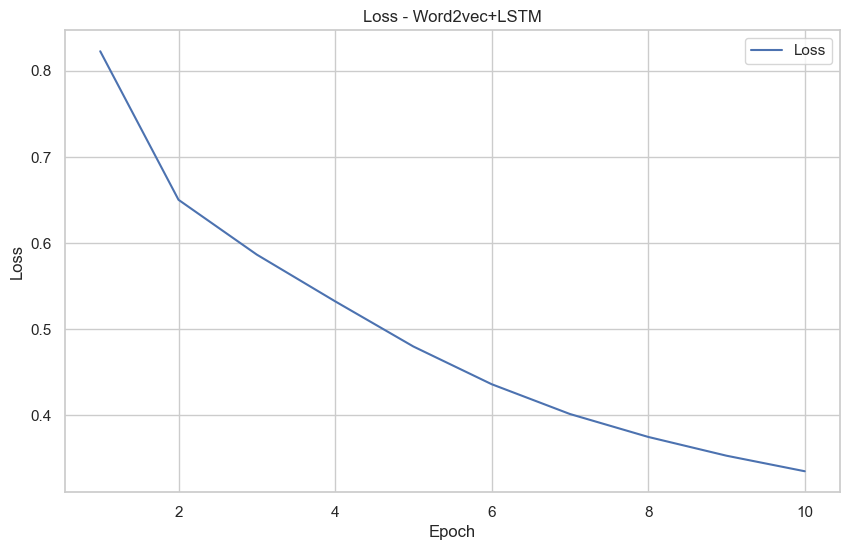

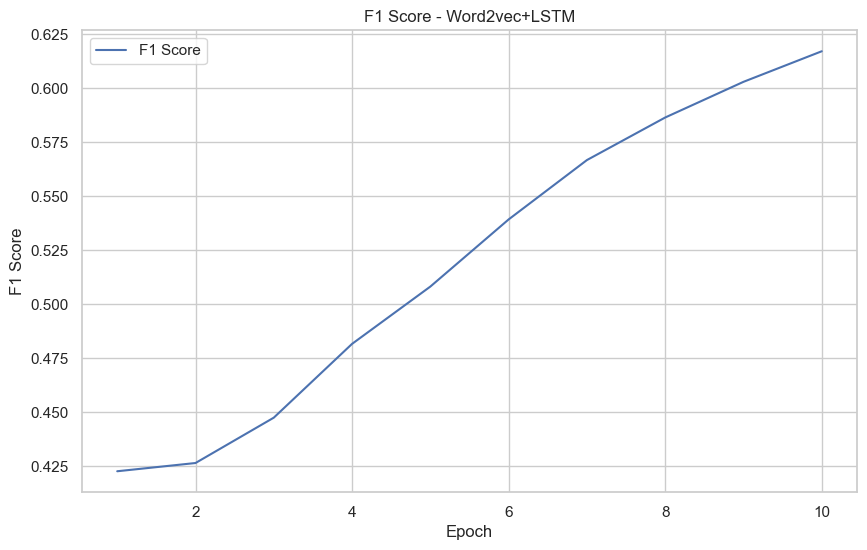

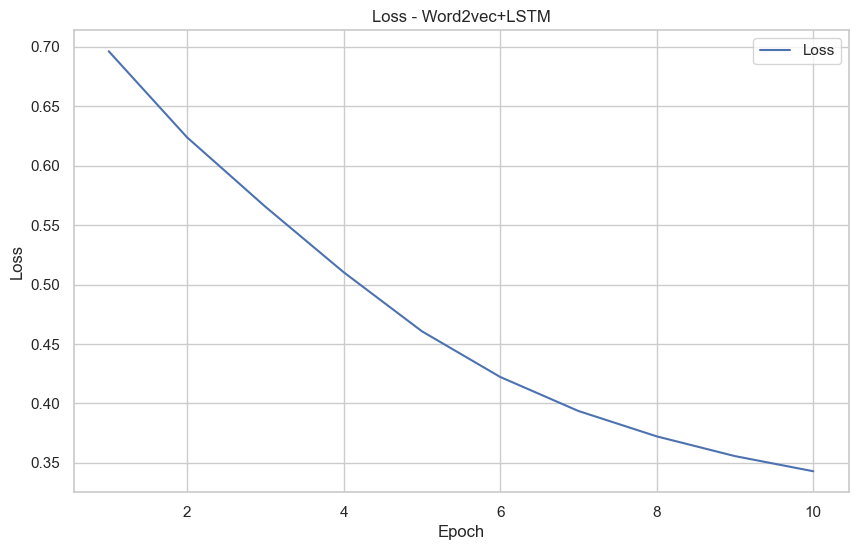

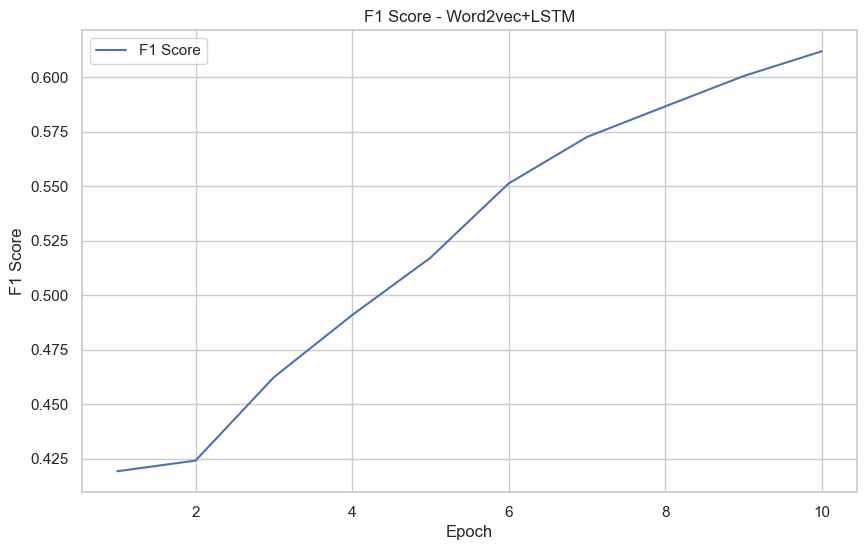

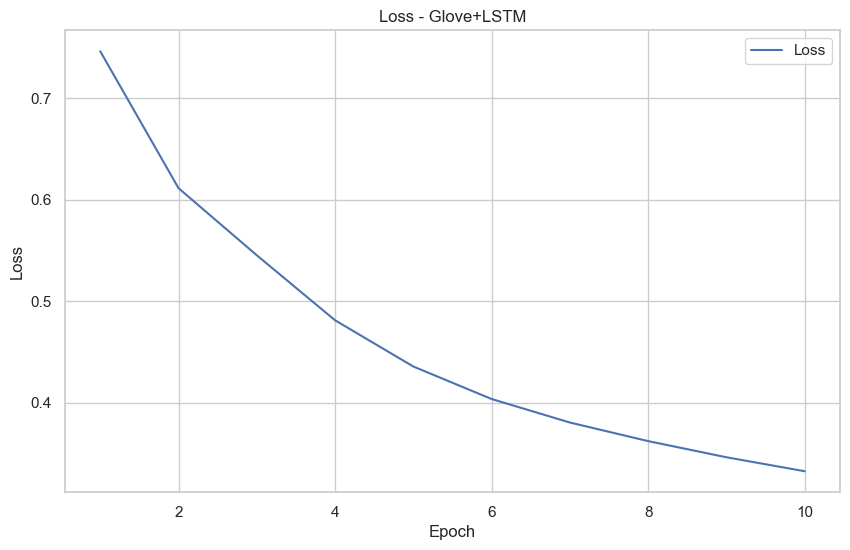

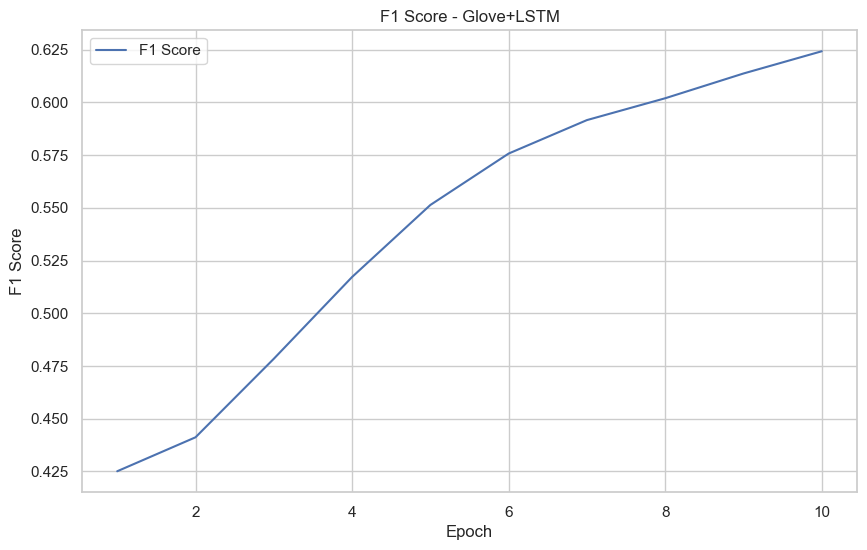

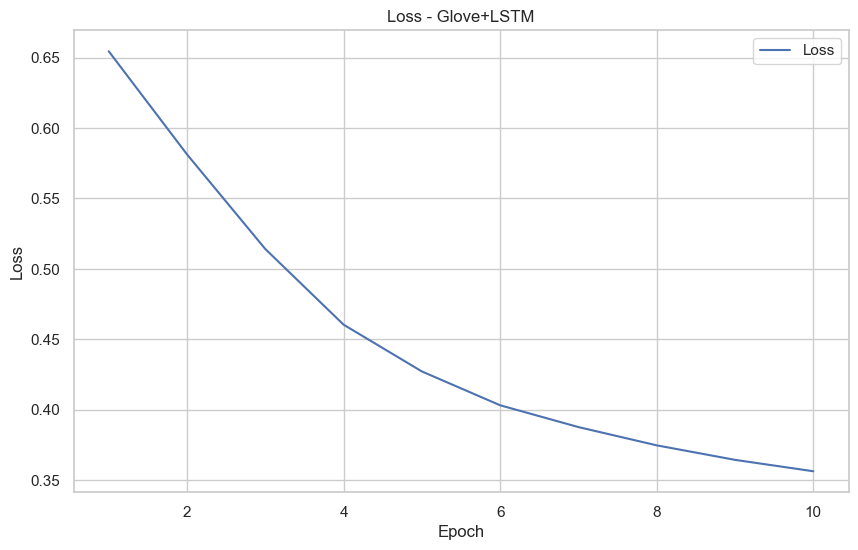

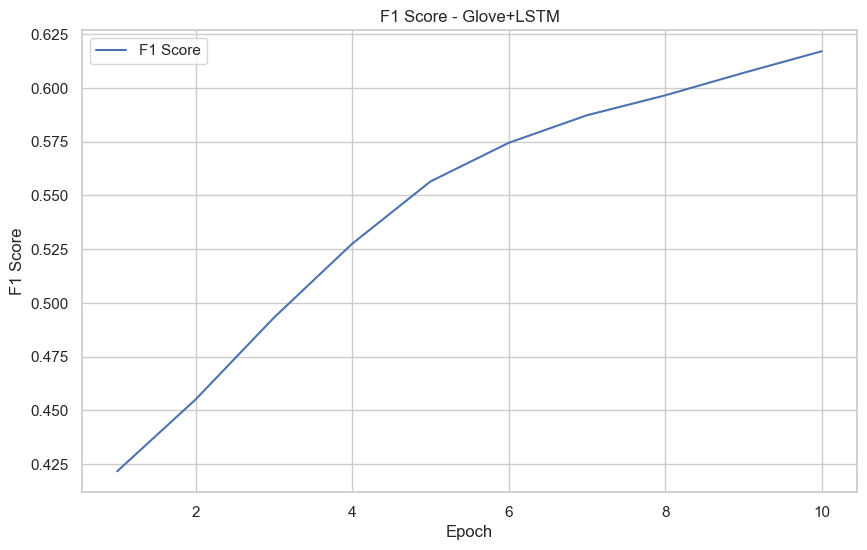

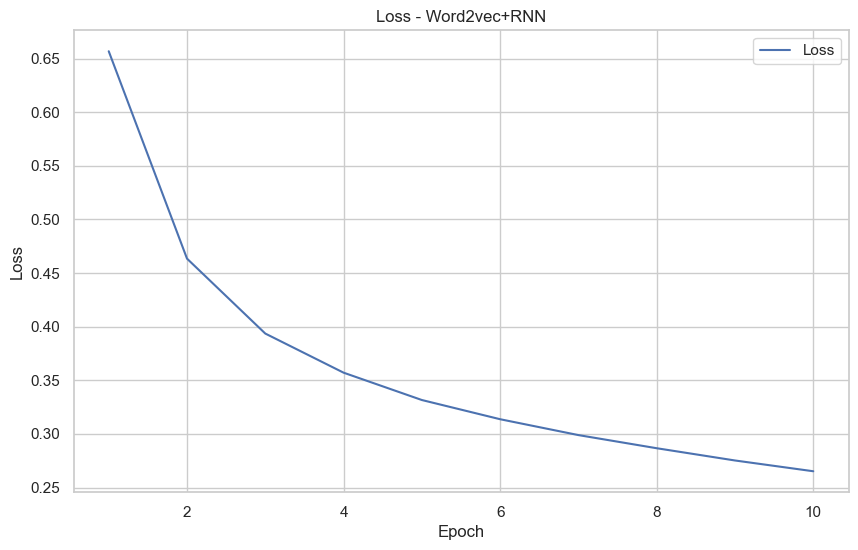

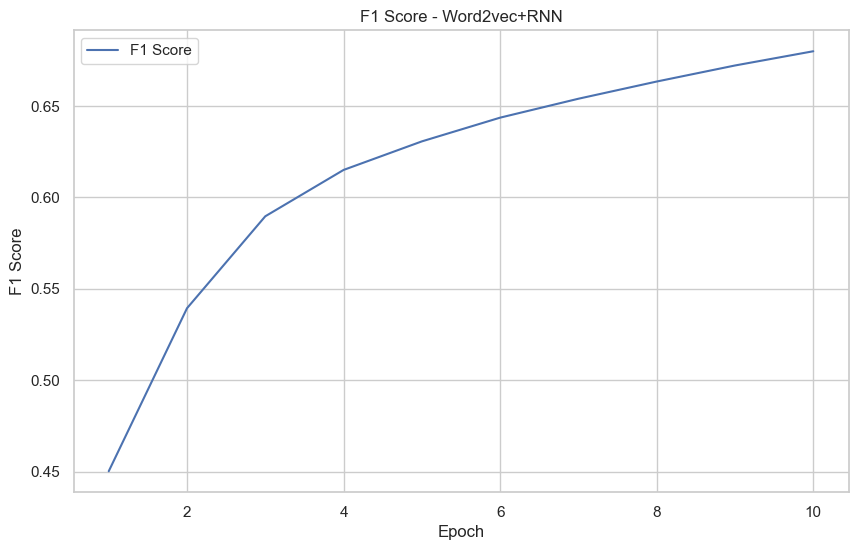

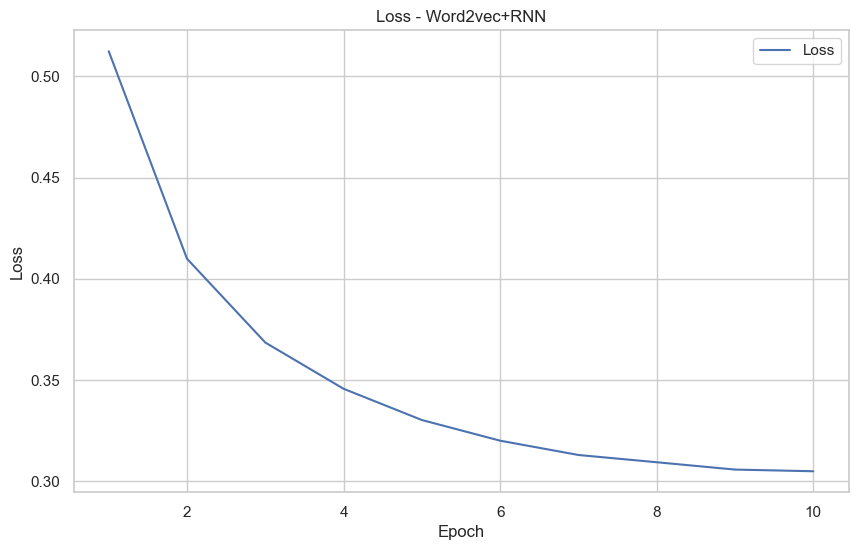

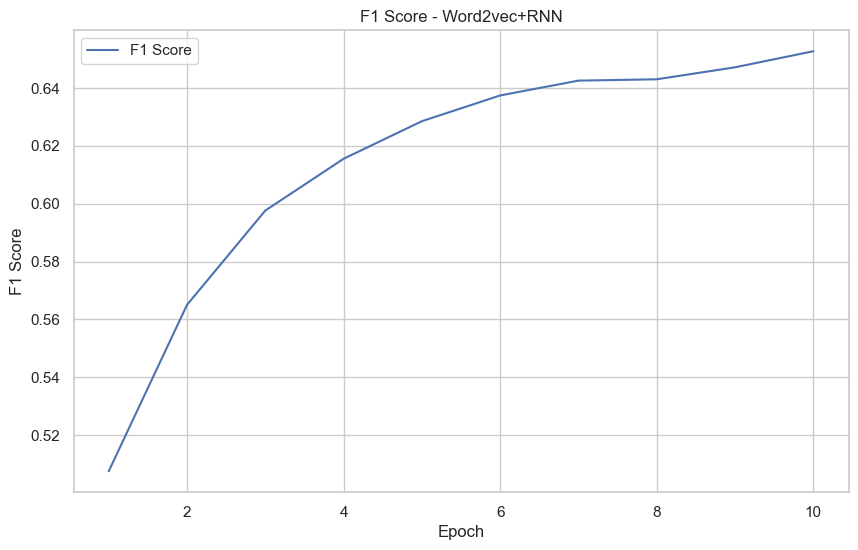

In [7]:
base_path = 'Part 2/Non Trainable Embeddings'
models = os.listdir(base_path)

for model in models:
    final_path = base_path + '/' + model
    train_losses = pickle.load(open(final_path + '/train_loss.pkl', 'rb'))
    val_losses = pickle.load(open(final_path + '/val_loss.pkl', 'rb'))
    train_f1s = pickle.load(open(final_path + '/train_f1.pkl', 'rb'))
    val_f1s = pickle.load(open(final_path + '/val_f1.pkl', 'rb'))

    plot_losses(train_losses, model)
    plot_f1s(train_f1s, model)
    plot_losses(val_losses, model)
    plot_f1s(val_f1s, model)

# Plotting BiLSTM-CRF

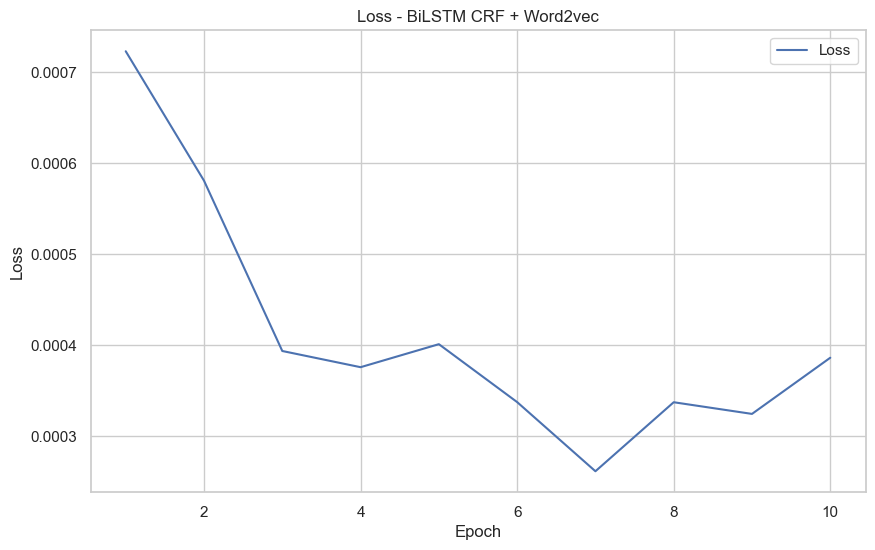

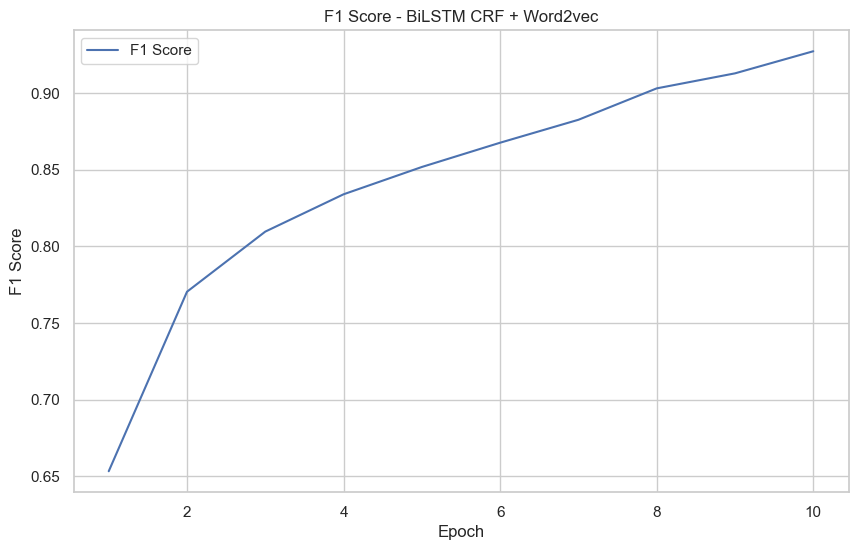

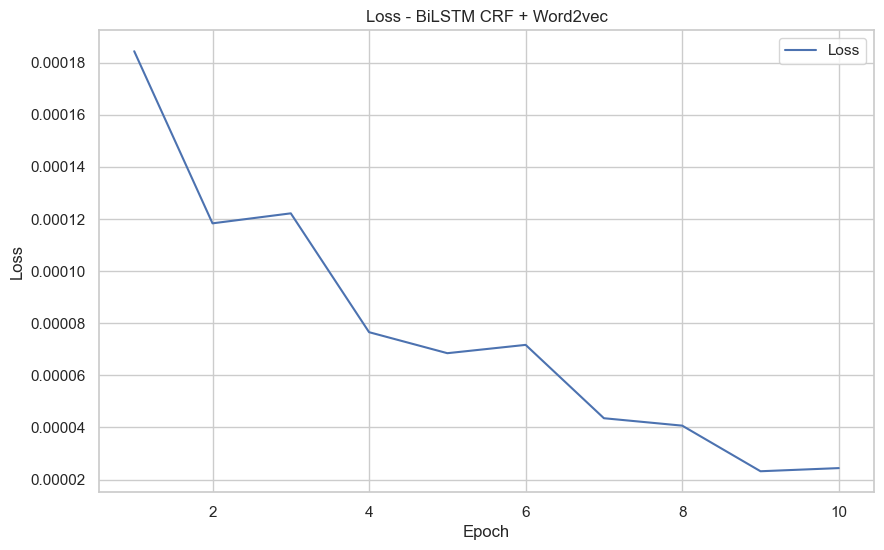

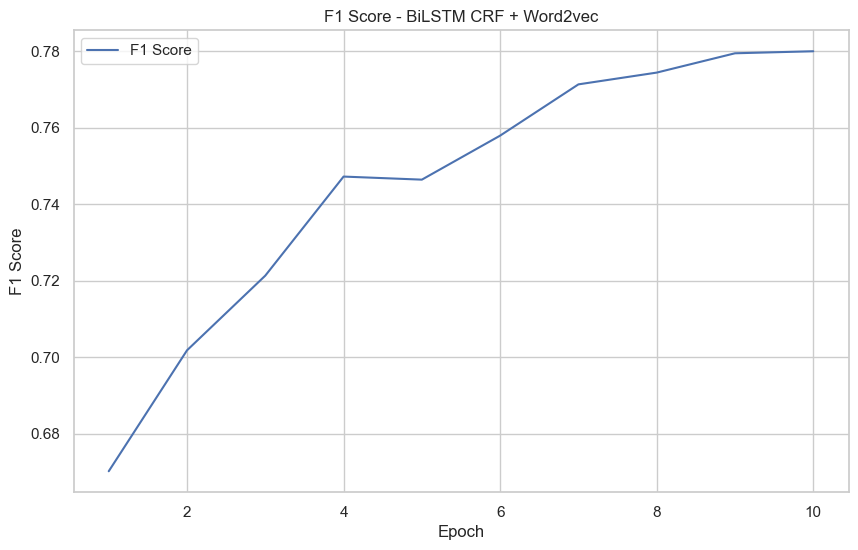

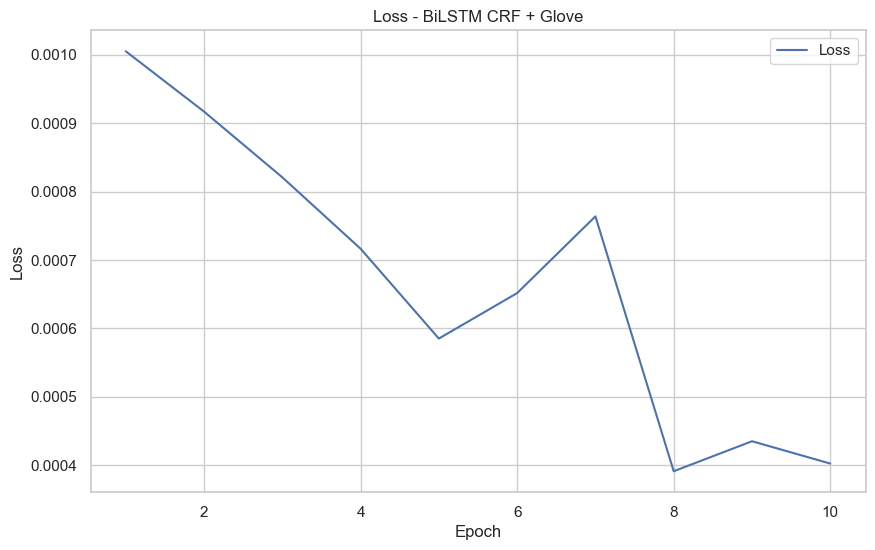

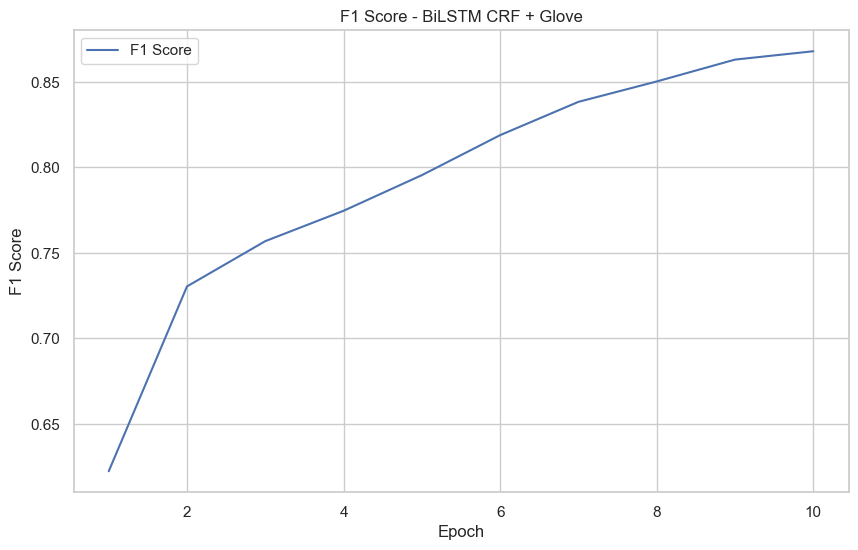

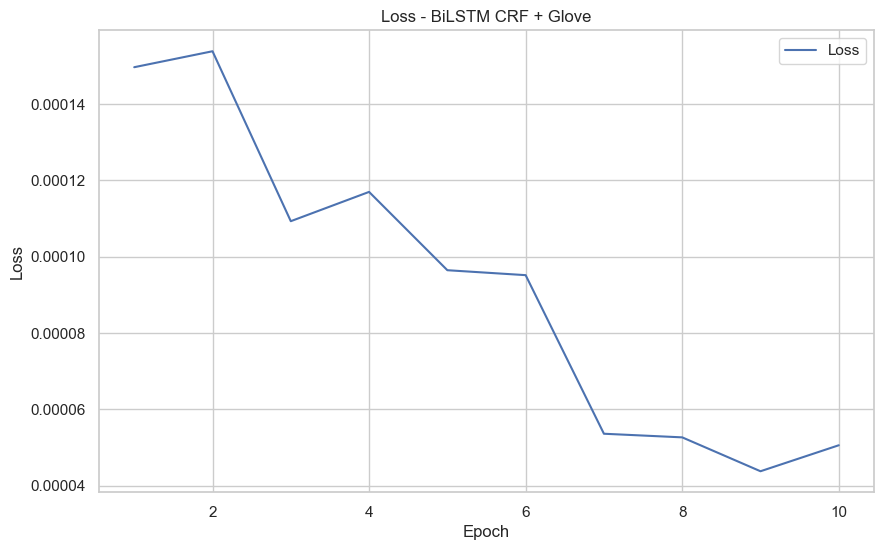

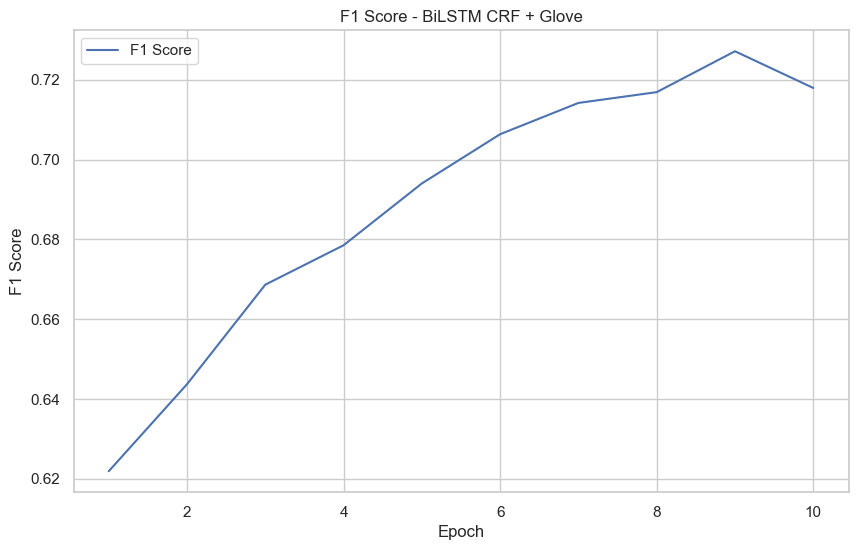

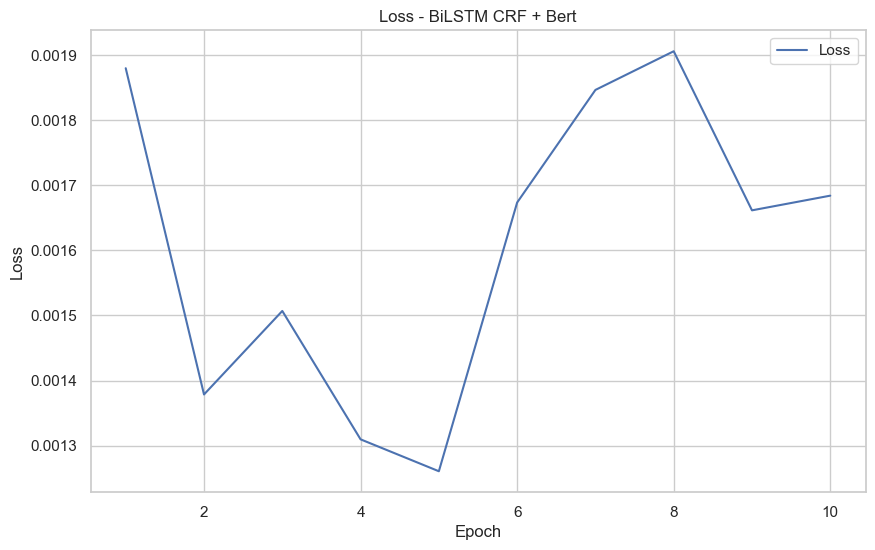

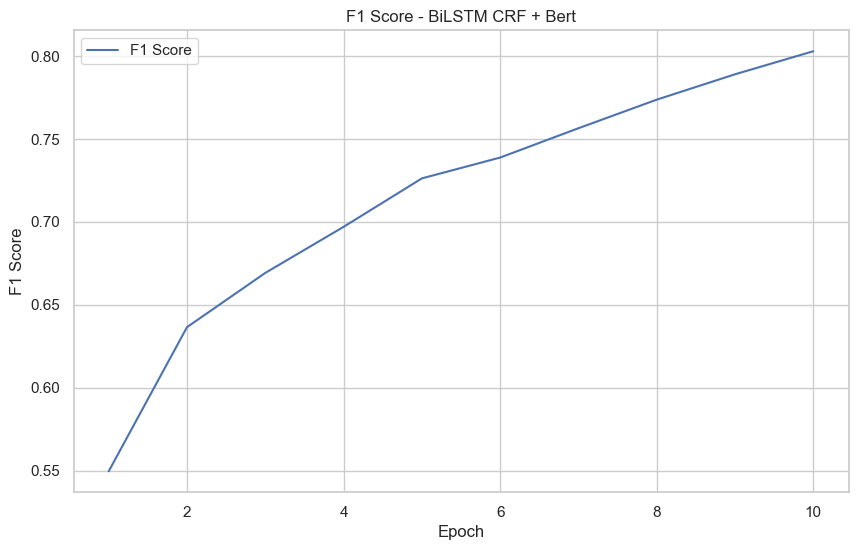

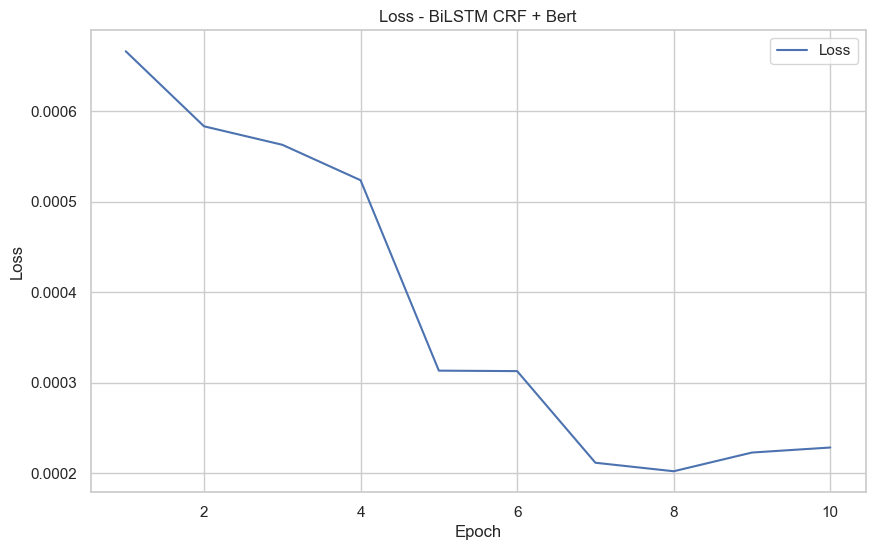

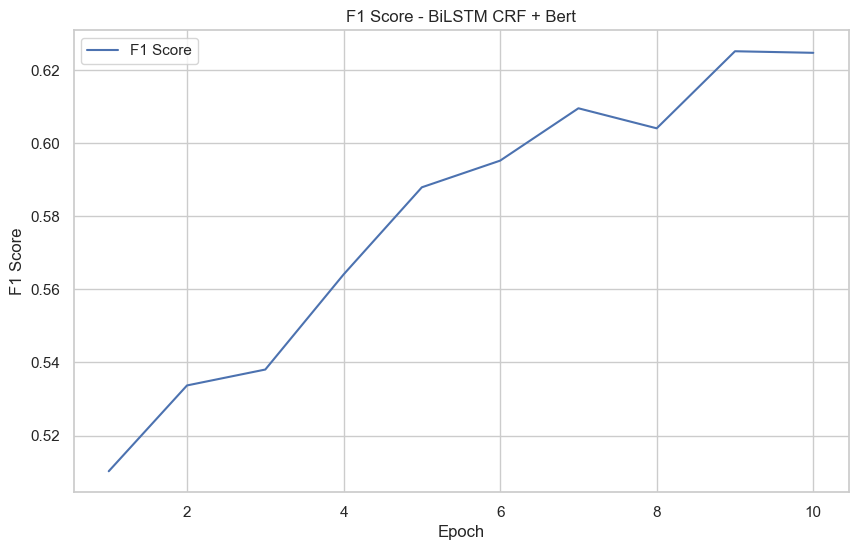

In [8]:
base_path = 'Part 3/Non Trainable Embeddings'
models = os.listdir(base_path)

for model in models:
    final_path = base_path + '/' + model
    train_losses = pickle.load(open(final_path + '/train_loss.pkl', 'rb'))
    train_losses = [float(loss.item()) for loss in train_losses]

    val_losses = pickle.load(open(final_path + '/val_loss.pkl', 'rb'))
    val_losses = [float(loss.item()) for loss in val_losses]

    train_f1s = pickle.load(open(final_path + '/train_f1.pkl', 'rb'))
    train_f1s = [float(f1.item()) for f1 in train_f1s]

    val_f1s = pickle.load(open(final_path + '/val_f1.pkl', 'rb'))
    val_f1s = [float(f1.item()) for f1 in val_f1s]

    plot_losses(train_losses, f'BiLSTM CRF + {model}')
    plot_f1s(train_f1s, f'BiLSTM CRF + {model}')
    plot_losses(val_losses, f'BiLSTM CRF + {model}')
    plot_f1s(val_f1s, f'BiLSTM CRF + {model}')

# Test Metrics

In [9]:
test_data = json.load(open('Dataset/NER_test.json'))

In [10]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

word_to_idx = pickle.load(open('Utils/word_to_idx.pkl', 'rb'))
tag_to_ix = pickle.load(open('Utils/tag_to_ix.pkl', 'rb'))

loss_function = nn.NLLLoss()

In [11]:
class RNN_model(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, embedding_mat, start_tag, end_tag, tag_to_ix, device='cpu'):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_mat)).to(device)
        self.rnn = nn.RNN(embedding_dim, hidden_dim).to(device)
        self.hidden2tag = nn.Linear(hidden_dim, target_size).to(device)
        self.start_tag = start_tag
        self.end_tag = end_tag
        self.tag_to_ix = tag_to_ix
        self.target_size = target_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        rnn_out, _ = self.rnn(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(rnn_out.view(len(sentence), -1))
        tag_scores = nn.functional.log_softmax(tag_space, dim=1)
        return tag_scores
    
class LSTM_model(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, embedding_mat, start_tag, end_tag, tag_to_ix, device='cpu'):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_mat)).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim).to(device)
        self.hidden2tag = nn.Linear(hidden_dim, target_size).to(device)
        self.start_tag = start_tag
        self.end_tag = end_tag
        self.tag_to_ix = tag_to_ix
        self.target_size = target_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = nn.functional.log_softmax(tag_space, dim=1)
        return tag_scores
    
class GRU_model(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, embedding_mat, start_tag, end_tag, tag_to_ix, device='cpu'):
        super(GRU_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_mat)).to(device)
        self.gru = nn.GRU(embedding_dim, hidden_dim).to(device)
        self.hidden2tag = nn.Linear(hidden_dim, target_size).to(device)
        self.start_tag = start_tag
        self.end_tag = end_tag
        self.tag_to_ix = tag_to_ix
        self.target_size = target_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        gru_out, _ = self.gru(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(gru_out.view(len(sentence), -1))
        tag_scores = nn.functional.log_softmax(tag_space, dim=1)
        return tag_scores

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, embedding_mat, start_tag, end_tag, tag_to_ix, batch_size=1, device='cpu'):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.target_size = target_size
        self.batch_size = batch_size
        self.device = device
        self.tag_to_ix = tag_to_ix
        self.start_tag = start_tag
        self.end_tag = end_tag

        self.embedding = nn.Embedding.from_pretrained(embedding_mat, freeze=False).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True).to(device)
        self.hidden2tag = nn.Linear(hidden_dim, target_size).to(device)

        self.transitions_to = nn.Parameter(torch.randn(target_size, target_size)).to(device)
        self.transitions_to.data[start_tag, :] = -10000
        self.transitions_to.data[:, end_tag] = -10000

        # self.transitions_from = nn.Parameter(torch.randn(target_size, target_size))
        # self.transitions_from.data[:, start_tag] = -10000
        # self.transitions_from.data[end_tag, :] = -10000

        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(self.device),
                torch.randn(2, 1, self.hidden_dim // 2).to(self.device))

    def get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.embedding(sentence).view(len(sentence), 1, -1)
        #convert embeds to torch float32
        embeds = embeds.float()
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats


    def _forward_algo(self, lstm_features):

        scores = torch.full((1, self.target_size), -10000.).to(self.device)
        scores[0][self.start_tag] = 0.

        forward_var = scores

        for feat in lstm_features:
            next_tag_var = self.transitions_to + feat.view(-1, 1).expand(-1, self.target_size) + forward_var.expand(self.target_size, -1)
            max_score = next_tag_var.max(dim=1).values.view(-1, 1)
            next_tag_var = next_tag_var - max_score
            forward_var = (max_score + torch.logsumexp(next_tag_var, dim=1).view(-1, 1)).view(1, -1)
            
        terminal_var = forward_var + (self.transitions_to[self.end_tag]).view(1, -1)
        alpha = terminal_var
        max_score = alpha.max()
        alpha = max_score + torch.logsumexp(alpha - max_score, dim=1)
        return alpha
    

    def _score_sentence(self, lstm_features, tags):
        score = torch.zeros(1).to(self.device)
        tags = torch.cat([torch.tensor([self.tag_to_ix['START_TAG']], dtype=torch.long).to(self.device), tags]).to(self.device)
        for i, feat in enumerate(lstm_features):
            score += self.transitions_to[tags[i + 1], tags[i]] + feat[tags[i + 1]]
                
        score += self.transitions_to[self.tag_to_ix['END_TAG'], tags[-1]]
        return score
    
    def neg_log_likelihood(self, sentence, tags):
        lstm_feats = self.get_lstm_features(sentence)
        forward_score = self._forward_algo(lstm_feats)
        gold_score = self._score_sentence(lstm_feats, tags)
        return forward_score - gold_score
    

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.target_size), -10000.).to(self.device)
        init_vvars[0][self.start_tag] = 0

        forward_var = init_vvars
        for feat in feats:
            bptrs_t = [] 
            viterbivars_t = [] 

            next_tag_var = self.transitions_to + forward_var.expand(self.target_size, -1)
            best_tag_id = torch.argmax(next_tag_var, dim=1)
            bptrs_t = best_tag_id
            viterbivars_t = next_tag_var[range(len(best_tag_id)), best_tag_id].view(1, -1)
            
            forward_var = (viterbivars_t + feat).view(1, -1)
            backpointers.append(bptrs_t)

        
        terminal_var = forward_var + self.transitions_to[self.end_tag]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

       
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id.item())
        
        start = best_path.pop()
        best_path.reverse()
        return path_score, best_path
        
    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self.get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [12]:
def evaluate(model, model_name):
    test_loss = 0
    test_f1 = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for case in tqdm(test_data):
            sentence = prepare_sequence(test_data[case]['text'].split(' '), word_to_idx)
            targets = prepare_sequence(test_data[case]['labels'], tag_to_ix)

            # Make predictions
            tag_scores = model(sentence)

            # Calculate loss
            loss = loss_function(tag_scores, targets)
            test_loss += loss.item()

            # Convert predictions and targets to numpy arrays
            predictions = torch.argmax(tag_scores, dim=1).detach().numpy()
            targets = targets.detach().numpy()

            # Collect predictions and targets for later evaluation
            all_predictions.extend(predictions)
            all_targets.extend(targets)

            # Calculate F1 score
            test_f1 += f1_score(targets, predictions, average='macro')

    # Calculate average test loss and F1 score
    avg_test_loss = test_loss / len(test_data)
    avg_test_f1 = test_f1 / len(test_data)

    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_predictions)    
    return {'Embedding': model_name, 'Test Macro-F1': avg_test_f1, 'Test Accuracy': accuracy}

In [13]:
def eval_BiLSTM(model, model_name):
    test_loss = 0
    test_f1 = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for case in tqdm(test_data):
            sentence = prepare_sequence(test_data[case]['text'].split(' '), word_to_idx)
            tags = prepare_sequence(test_data[case]['labels'], tag_to_ix)
            # sentence = sentence.to(device)
            # tags = tags.to(device)

            # Calculate loss
            loss = model.neg_log_likelihood(sentence, tags)
            test_loss += loss.item()

            # Make predictions
            _, preds = model(sentence)
            # preds = preds.cpu().numpy()
            # tags = tags.cpu().numpy()

            # Collect predictions and targets for later evaluation
            all_predictions.extend(preds)
            all_targets.extend(tags)

            # Calculate F1 score
            test_f1 += f1_score(tags, preds, average='macro')

    # Calculate average test loss and F1 score
    avg_test_loss = test_loss / len(test_data)
    avg_test_f1 = test_f1 / len(test_data)

    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_predictions)    
    return {'Embedding': model_name, 'Test Macro-F1': avg_test_f1, 'Test Accuracy': accuracy}

In [ ]:
eval_metrics = {}
base_path = 'Part 2/Non Trainable Embeddings'
models = os.listdir(base_path)

for model_name in models:
    final_path = base_path + '/' + model_name + '/model.pt'
    model = torch.load(final_path)
    model.eval()
    eval_metrics[model_name] = evaluate(model, model_name)

base_path = 'Part 3/Non Trainable Embeddings'
models = os.listdir(base_path)

for model_name in models:
    final_path = base_path + '/' + model_name + '/model.pt'
    model = torch.load(final_path)
    model.eval()
    eval_metrics[f'{model_name}+BiLSTM-CRF'] = eval_BiLSTM(model, model_name)

In [ ]:
df = pd.DataFrame(eval_metrics).transpose().reset_index()
df.rename(columns={'index': 'Model'}, inplace=True)
df